In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
     for filename in filenames:
        print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-spoiler-dataset/IMDB_movie_details.json
/kaggle/input/imdb-spoiler-dataset/IMDB_reviews.json
/kaggle/input/glove-embeddings/glove.6B.200d.txt
/kaggle/input/glove-embeddings/glove.6B.50d.txt
/kaggle/input/glove-embeddings/glove.6B.300d.txt
/kaggle/input/glove-embeddings/glove.6B.100d.txt


## Important Library

In [3]:
# regular expression and string case
import re
import string

# Data reading
import pandas as pd
import numpy as np

# tensorflow and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_datasets as tfds

# Sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Read the dataset
df_reviews = pd.read_json('../input/imdb-spoiler-dataset/IMDB_reviews.json', lines=True)
df_details = pd.read_json('../input/imdb-spoiler-dataset/IMDB_movie_details.json',lines =True)

### Function to get a equal number of data from both classification  

In [5]:
def get_part_data(df, num_reviews):
    
    num_pos_reviews = df[df["is_spoiler"]== True].shape[0]  # Number of spoilers in the dataset
    num_neg_reviews = df[df["is_spoiler"]== False].shape[0] # Number of Non-spoilers in the dataset
    
    fraction_pos = num_reviews/num_pos_reviews  # fraction of spoiler reviews to be returned
    fraction_neg = num_reviews/num_neg_reviews  # fraction of non-spoiler reviews to be returned 

    df_pos = df[df['is_spoiler'] == True].sample(frac = fraction_pos, random_state = 2)
    df_neg = df[df['is_spoiler'] == False].sample(frac = fraction_neg, random_state = 2)

    df_re = pd.concat([df_pos, df_neg])  # join the True and False dataset
    df_re = df_re.reset_index(drop=True)  # mix the index values
    df_re.loc[(df_re['is_spoiler'] == True) ,'is_spoiler'] =1
    df_re.loc[(df_re['is_spoiler'] == False) ,'is_spoiler'] =0
    return df_re[["movie_id","review_text","review_summary","is_spoiler"]]

In [6]:
old_data = get_part_data(df_reviews, 110000)

## Preprocess the data

In [7]:
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", 
             "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during",
             "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", 
             "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into",
             "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or",
             "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", 
             "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's",
             "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up",
             "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's",
             "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've",
             "your", "yours", "yourself", "yourselves" ]

In [8]:
# Removing the stop word and tags
def remove_stopwords(data):
    data['review_ws'] = data['review_text'].apply(lambda x :' '.join([word for word in x.split() 
                                                                 if word not in (stopwords)]))
    return data

def remove_tags(string):
    result = re.sub('<.*?>','',string)
    return result
    
# open new a feature as cleaned review text
data_ws = remove_stopwords(old_data)
data_ws['clean_review']= data_ws['review_ws'].apply(lambda cw : remove_tags(cw))
data_ws['clean_review'] = data_ws['clean_review'].str.replace('[{}]'.format(string.punctuation), ' ')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [9]:
# label encoder used to tranform the labels
le = LabelEncoder()

# train and test split
training_reviews,testing_reviews,training_labels,testing_labels  = train_test_split(data_ws['clean_review'].values,old_data['is_spoiler'].values,test_size = 0.2)
training_labels = le.fit_transform(training_labels)
testing_labels = le.fit_transform(testing_labels)

In [10]:
# Shape of train and test data
print(training_reviews.shape)
print(testing_reviews.shape)

(176000,)
(44000,)


### Tokenize the text
Using tokenizer to produce token for a given word and taking maximum length of 400 character of a review and after we simply truncate the input review and then padded the input to max len of 400

In [11]:
# Tokenize the text 
tokenizer = Tokenizer(num_words=10000,oov_token='<OOV>')
tokenizer.fit_on_texts(training_reviews)
word_index = tokenizer.word_index
training_sequence = tokenizer.texts_to_sequences(training_reviews)
testing_sequence = tokenizer.texts_to_sequences(testing_reviews)

# covert the text into padded sequence
train_pad_sequence = pad_sequences(training_sequence,maxlen = 400,truncating= 'post',padding = 'pre')
test_pad_sequence = pad_sequences(testing_sequence,maxlen = 400,truncating= 'post',padding = 'pre')
print('Total Unique Words : {}'.format(len(word_index)))

Total Unique Words : 171045


### Using Glove embedding with LSTM layer

layer1: Embedding Layer using glove weights

layer2: Using a Bidirectional LSTM

layer3: A dropout Layer

layer4: A Dense layer of 256 neurons with 'relu' activation

layer5: A Dense Layer of 128 neurons with 'relu' activation

layer6: Again a dropout layer.

layer7: Sigmoid activation layer to classify it positive and negative.

In [12]:
# Getting the Glove embedding text
embedded_words = {}
with open('../input/glove-embeddings/glove.6B.300d.txt') as file:
    for line in file:
        words, coeff = line.split(maxsplit=1)
        coeff = np.array(coeff.split(),dtype = float)
        embedded_words[words] = coeff

In [13]:
# Check the word items using Glove embedding
embedding_matrix = np.zeros((len(word_index) + 1,300))
for word, i in word_index.items():
    embedding_vector = embedded_words.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [14]:
# Built the Bi-LSTM model using tensorflow.keras
model = tf.keras.Sequential([tf.keras.layers.Embedding(len(word_index) + 1,300,weights=[embedding_matrix],input_length=300,
                            trainable=False),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(256,activation = 'relu',),
                             tf.keras.layers.Dense(128,activation = 'relu'),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(1,activation = tf.nn.sigmoid)])

2022-03-19 18:45:07.117773: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 18:45:07.259303: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 18:45:07.260451: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 18:45:07.261944: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          51313800  
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               186880    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

In [16]:
# Compile the loss using cross entropy function
model.compile(loss = tf.keras.losses.BinaryCrossentropy() , optimizer='Adam' , metrics = 'accuracy')
history = model.fit(train_pad_sequence,training_labels,epochs = 10 ,validation_data=(test_pad_sequence,testing_labels))

2022-03-19 18:45:11.371258: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-03-19 18:45:15.722290: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


5500/5500 [==============================] - 210s 37ms/step - loss: 0.6701 - accuracy: 0.5763 - val_loss: 0.6065 - val_accuracy: 0.6753
Epoch 2/10
5500/5500 [==============================] - 204s 37ms/step - loss: 0.5940 - accuracy: 0.6839 - val_loss: 0.5724 - val_accuracy: 0.6910
Epoch 3/10
5500/5500 [==============================] - 203s 37ms/step - loss: 0.5737 - accuracy: 0.6987 - val_loss: 0.5649 - val_accuracy: 0.7040
Epoch 4/10
5500/5500 [==============================] - 202s 37ms/step - loss: 0.5623 - accuracy: 0.7071 - val_loss: 0.5649 - val_accuracy: 0.6990
Epoch 5/10
5500/5500 [==============================] - 201s 37ms/step - loss: 0.5528 - accuracy: 0.7145 - val_loss: 0.5599 - val_accuracy: 0.7066
Epoch 6/10
5500/5500 [==============================] - 201s 37ms/step - loss: 0.5427 - accuracy: 0.7228 - val_loss: 0.5626 - val_accuracy: 0.7065
Epoch 7/10
5500/5500 [==============================] - 201s 37ms/step - loss: 0.5311 - accuracy: 0.7300 - val_loss: 0.5615 - val

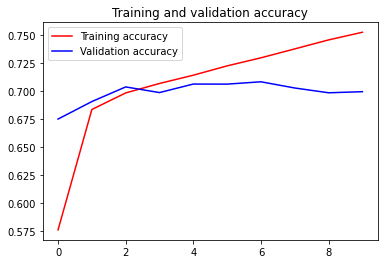

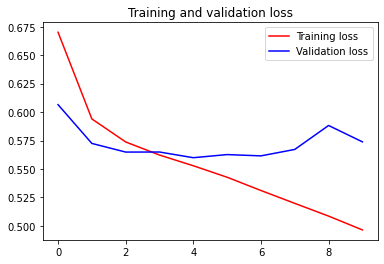

In [17]:
# Evaluate the model using accuracy and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

plt.show()

In [18]:
print('Training Accuracy: {}'.format(max(acc)))
print('Validation Accuracy: {}'.format(max(val_acc)))

Training Accuracy: 0.7528863549232483
Validation Accuracy: 0.7086363434791565


In [19]:

predictions = (model.predict(test_pad_sequence) > 0.5).astype("int32")

### Evaluation Report

In [20]:
from sklearn.metrics import classification_report
report = classification_report(testing_labels,predictions)
print(report)

              precision    recall  f1-score   support

           0       0.68      0.77      0.72     22155
           1       0.73      0.63      0.67     21845

    accuracy                           0.70     44000
   macro avg       0.70      0.70      0.70     44000
weighted avg       0.70      0.70      0.70     44000



### AUC score for the Glove embedding using BI-LStm Model

In [21]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(testing_labels, predictions ))

0.6992724535551584
